In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt 
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
from pyproj import CRS, Transformer

: 

In [ ]:
print("hey")

# Extracting necessary SINMOD data

Extracting more than a few time steps will take a while and potentially cause crashing. Then we will need to run on IDUN. Can set up via VS code ssh.

We will now:
- Look at a few data sets to check the numbers make sense
- Standardise and normalise the data

In [ ]:


# Importing SINMOD data
filename_PhysStates = 'PhysStates.nc'

PhysStates_data = Dataset(filename_PhysStates, 'r')

# Looking at our list of available variables
variables_list = list(PhysStates_data.variables.keys())
for variable in variables_list:
    units = PhysStates_data.variables[variable].units if 'units' in PhysStates_data.variables[variable].ncattrs() else 'No units'
    print(f"{variable:<20} {units}")

NameError: name 'Dataset' is not defined

In [3]:
# Extracting all the map dimensions, we can extract both ways, I don't think it matters
xc = PhysStates_data.variables['xc'][:]  # x-coordinates (meters)
yc = PhysStates_data.variables['yc'][:]  # y-coordinates (meters)
zc = PhysStates_data['LayerDepths'][:]  # z-coordinates (meters)

# Now checking temperature data matches what we expect from the dimensions
# Extracting temperature at t = 0, and check the dimensions
temperature_var = PhysStates_data.variables['temperature']
temperature = temperature_var[0,:,:,:]
print("SINMOD grid dimensions:")
print(f"xc shape: {xc.shape}")
print(f"yc shape: {yc.shape}")
print(f"zc shape: {zc.shape}")

print(f"\nTemperature data shape: {temperature.shape}")
# Now checking mean, max and min temperature to see if it makes sense
print(f"Mean temperature:\t{temperature.mean():.2f}")
print(f"Max temperature:\t{temperature.max():.2f}")
print(f"Min temperature:\t{temperature.min():.2f}")

# Repeating for salinity
salinity_var = PhysStates_data.variables['salinity']
salinity = salinity_var[0,:,:,:]

print(f"\nSalinity data shape:\t{salinity.shape}")
print(f"Mean salinity:\t\t{salinity.mean():.2f}")
print(f"Max salinity:\t\t{salinity.max():.2f}")
print(f"Min salinity:\t\t{salinity.min():.2f}")


SINMOD grid dimensions:
xc shape: (300,)
yc shape: (235,)
zc shape: (25,)

Temperature data shape: (25, 235, 300)
Mean temperature:	1.64
Max temperature:	10.86
Min temperature:	-1.80

Salinity data shape:	(25, 235, 300)
Mean salinity:		34.23
Max salinity:		37.26
Min salinity:		0.10


In [ ]:
from sklearn.preprocessing import StandardScaler

# Many options for what sort of standardisation we want here, but a simple one:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the temperature and salinity data
temperature_standardized = scaler.fit_transform(temperature.reshape(-1, 1)).reshape(temperature.shape)
salinity_standardized = scaler.fit_transform(salinity.reshape(-1, 1)).reshape(salinity.shape)

# Print the mean and standard deviation of the standardised data to verify
print(f"Standardised Temperature - Mean: {temperature_standardized.mean():.2f}, Std Dev: {temperature_standardized.std():.2f}")
print(f"Standardised Salinity - Mean: {salinity_standardized.mean():.2f}, Std Dev: {salinity_standardized.std():.2f}")

Standardised Temperature - Mean: -0.00, Std Dev: 1.00
Standardised Salinity - Mean: -0.00, Std Dev: 1.00


In [5]:
# We want to save this processed data, there are multiple options:
# 1. NetCDF
# 2. Pandas (2D data)
# 3. Xarray ()
# Need to determine best method

Now repeating for Biostates

In [7]:
# Importing BioStates data
filename_BioStates = 'BioStates.nc'

BioStates_data = Dataset(filename_BioStates, 'r')

# Looking at our list of available variables
bio_variables_list = list(BioStates_data.variables.keys())
for variable in bio_variables_list:
    units = BioStates_data.variables[variable].units if 'units' in BioStates_data.variables[variable].ncattrs() else 'No units'
    print(f"{variable:<20} {units}")

time                 No units
grid_mapping         No units
LayerDepths          m
xc                   meter
yc                   meter
zc                   m
depth                m
DXxDYy               m2
nitrate              mmmol N m-3
silicate             mmmol N m-3
ammonium             mmmol N m-3
diatoms              mmmol N m-3
flagellates          mmmol N m-3
ciliates             mmmol N m-3
HNANO                mmmol N m-3
bacteria             mmmol N m-3
calanus_finmarchicus gC m-2
calanus_glacialis    gC m-2
detritus_slow        mmmol N m-3
detritus_fast        mmmol N m-3
DOC                  mmmol N m-3
cDOM                 m-1
silicate_detritus    mmmol N m-3
sediment_Si          mmmol Si m-2
sediment_N           mmmol N m-2


In [8]:
# Extracting silicate and DOC data
silicate_var = BioStates_data.variables['silicate']
DOC_var = BioStates_data.variables['DOC']

# Extracting silicate and DOC at t = 0, and check the dimensions
silicate = silicate_var[0, :, :, :]
DOC = DOC_var[0, :, :, :]

print("Silicate data shape:", silicate.shape)
print(f"Mean silicate:\t{silicate.mean():.2f}")
print(f"Max silicate:\t{silicate.max():.2f}")
print(f"Min silicate:\t{silicate.min():.2f}")

print("\nDOC data shape:", DOC.shape)
print(f"Mean DOC:\t{DOC.mean():.2f}")
print(f"Max DOC:\t{DOC.max():.2f}")
print(f"Min DOC:\t{DOC.min():.2f}")

Silicate data shape: (25, 235, 300)
Mean silicate:	7.53
Max silicate:	99.98
Min silicate:	0.10

DOC data shape: (25, 235, 300)
Mean DOC:	0.00
Max DOC:	0.14
Min DOC:	0.00


# Extracting coral data and transforming to SINMOD co-ordinate system

1. Transformation to SINMOD co-ordinates
- What cleaning steps should do?

In [12]:

# Importing coral reef data

# gml_file_coral_reefs = "./KystOgFiskeri_50_Trondelag_25832_Korallrev_GML.gml"
gml_file_coral_reefs = "KystOgFiskeri_50_Trondelag_25832_Korallrev_GML.gml"

gdf_coral_reefs_trondelag = gpd.read_file(gml_file_coral_reefs)

# Not sure this is necessary since all the naturtypeNavn are the same
# unique_naturtypeNavn = gdf_coral_reefs_trondelag['naturtypeNavn'].unique()
# print(unique_naturtypeNavn)

coral_data = gdf_coral_reefs_trondelag[gdf_coral_reefs_trondelag['naturtypeNavn'] == 'Korallforekomster']

coral_location_df = coral_data[['lengdegrad', 'breddegrad']]

# Display the columns of the coral reef data
print(coral_data.columns)

Index(['gml_id', 'lokalId', 'navnerom', 'verifiseringsdato', 'produkt',
       'versjon', 'målemetode', 'nøyaktighet', 'medium', 'opphav',
       'minimumsdybde', 'maksimumsdybde', 'naturtype', 'naturtypeNavn',
       'kildeNavn', 'observasjonsMetode', 'observasjonsSted',
       'observasjonsSlutt', 'lengdegrad', 'breddegrad', 'geometry'],
      dtype='object')


In [13]:


def obtain_sinmod_crs(PhysStates_data):
    # Print grid mapping to see details, particularly the horizontal resolution
    grid_mapping = PhysStates_data.variables['grid_mapping']
    print(grid_mapping)

    horizontal_resolution = grid_mapping.getncattr('horizontal_resolution')
    print(f"\nHorizontal resolution: {horizontal_resolution} meters")

    crs_sinmod = CRS.from_proj4(f"+proj=stere "
                                f"+lat_0={grid_mapping.latitude_of_projection_origin} "
                                f"+lat_ts={grid_mapping.standard_parallel} "
                                f"+lon_0={grid_mapping.straight_vertical_longitude_from_pole} "
                                f"+x_0={grid_mapping.false_easting} "
                                f"+y_0={grid_mapping.false_northing} "
                                f"+a={grid_mapping.semi_major_axis} "
                                f"+b={grid_mapping.semi_minor_axis} "
                                f"+units=m +no_defs")
    
    print(f"\n Determined SINMOD CRS: {crs_sinmod}")
    return crs_sinmod

# Example usage
crs_sinmod = obtain_sinmod_crs(PhysStates_data)


<class 'netCDF4._netCDF4.Variable'>
int32 grid_mapping()
    grid_mapping_name: polar_stereographic
    straight_vertical_longitude_from_pole: 58.0
    horizontal_resolution: 20000.0
    latitude_of_projection_origin: 90.0
    longitude_of_projection_origin: 58.0
    standard_parallel: 60.0
    origoRef: [0. 0.]
    semi_minor_axis: 6370000.0
    semi_major_axis: 6370000.0
    false_easting: 3900000.0
    false_northing: 2570000.0
    scale_factor_at_projection_origin: 1.0
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

Horizontal resolution: 20000.0 meters

 Determined SINMOD CRS: +proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=58.0 +x_0=3900000.0 +y_0=2570000.0 +a=6370000.0 +b=6370000.0 +units=m +no_defs +type=crs


In [19]:
from pyproj import CRS, Transformer

def transform_coral_coordinates(coral_data, crs_sinmod=CRS.from_proj4("+proj=stere +lat_0=90 +lat_ts=60 +lon_0=58 "
                                "+x_0=3900000 +y_0=2570000 +a=6370000 +b=6370000 +units=m +no_defs")):
    # Define the Coordinate Reference Systems (CRS) for the coral data
    crs_wgs84 = CRS.from_epsg(4326)  # WGS84 (lat/lon coordinates)

    # Create a transformer to transform from wgs84 (geographic) to SINMOD
    transformer_wgs84_to_sinmod = Transformer.from_crs(crs_wgs84, crs_sinmod, always_xy=True)

    # # Performing projection on coral reef data
    # print("coral_lons range before:", coral_data['lengdegrad'].min(), coral_data['lengdegrad'].max())
    # print("coral_lats range before:", coral_data['breddegrad'].min(), coral_data['breddegrad'].max())
    # print("--------------------------------")

    # Transform coral coordinates from WGS84 to SINMOD
    coral_x, coral_y = transformer_wgs84_to_sinmod.transform(coral_data['lengdegrad'], coral_data['breddegrad'])

    # # The values after are NOT lat lon, but rather the SINMOD grid coordinates 
    # print("coral_lons grid-coordinates:", coral_x.min(), coral_x.max())
    # print("coral_lats grid-coordinates:", coral_y.min(), coral_y.max())

    # Save coral_x and coral_y as new columns called x and y
    coral_data.loc[:, 'x'] = coral_x
    coral_data.loc[:, 'y'] = coral_y

    return coral_data

# Example usage
coral_data = transform_coral_coordinates(coral_location_df)

coral_data.to_csv('coral_data.csv', index=False)


# Save the dataframe to a parquet file
#coral_data.to_parquet('./processed_data/coral_data_trondelag_processed.parquet', index=False)

<class 'netCDF4._netCDF4.Variable'>
int32 grid_mapping()
    grid_mapping_name: polar_stereographic
    straight_vertical_longitude_from_pole: 58.0
    horizontal_resolution: 800.0
    latitude_of_projection_origin: 90.0
    longitude_of_projection_origin: 58.0
    standard_parallel: 60.0
    origoRef: [0. 0.]
    semi_minor_axis: 6370000.0
    semi_major_axis: 6370000.0
    false_easting: 2544800.0
    false_northing: 1918800.0
    scale_factor_at_projection_origin: 1.0
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

Horizontal resolution: 800.0 meters

 Determined SINMOD CRS: +proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=58.0 +x_0=2544800.0 +y_0=1918800.0 +a=6370000.0 +b=6370000.0 +units=m +no_defs +type=crs


/tmp/ipykernel_849434/35602525.py:16: RuntimeWarning: invalid value encountered in sqrt
  current_speed_subset = np.sqrt(phystates_data.variables['u_velocity'][0, 0, y_range[0]:y_range[1], x_range[0]:x_range[1]]**2 +
/cluster/home/haroldh/.conda/envs/SINMOD/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


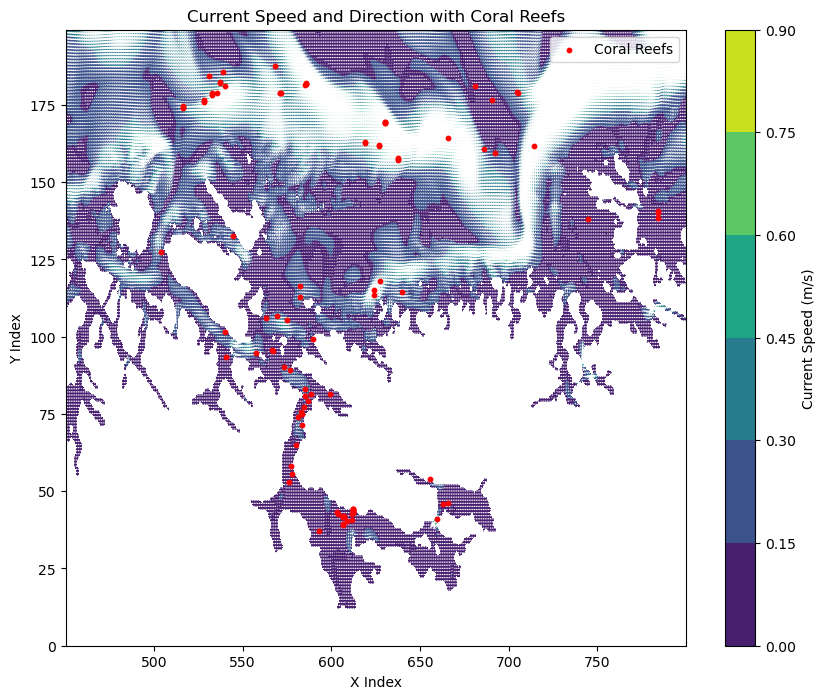

In [ ]:
def plot_coral_on_nor4km(phystates_data, coral_data, x_range=None, y_range=None):

    crs  = obtain_sinmod_crs(phystates_data)

    # Extracting necessary data from nor4km PhysStates.nc
    xc = phystates_data.variables['xc'][:]  # x-coordinates (meters)
    yc = phystates_data.variables['yc'][:]  # y-coordinates (meters)

    x = np.linspace(0, xc.shape[0], xc.shape[0])
    y = np.linspace(0, yc.shape[0], yc.shape[0])

    coral_data = transform_coral_coordinates(coral_data, crs)

    # If x_range and y_range are provided, extract the subset of the data
    if x_range and y_range:
        current_speed_subset = np.sqrt(phystates_data.variables['u_velocity'][0, 0, y_range[0]:y_range[1], x_range[0]:x_range[1]]**2 + 
                                       phystates_data.variables['v_velocity'][0, 0, y_range[0]:y_range[1], x_range[0]:x_range[1]]**2)
        x_subset = x[x_range[0]:x_range[1]]
        y_subset = y[y_range[0]:y_range[1]]
        u_velocity_subset = phystates_data.variables['u_velocity'][0, 0, y_range[0]:y_range[1], x_range[0]:x_range[1]]
        v_velocity_subset = phystates_data.variables['v_velocity'][0, 0, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    else:
        current_speed_subset = np.sqrt(phystates_data.variables['u_velocity'][0, 0, :, :]**2 + 
                                       phystates_data.variables['v_velocity'][0, 0, :, :]**2)
        x_subset = x
        y_subset = y
        u_velocity_subset = phystates_data.variables['u_velocity'][0, 0, :, :]
        v_velocity_subset = phystates_data.variables['v_velocity'][0, 0, :, :]
    
    hor_res = phystates_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    # Plot the transformed coral data points on top of the nor4km SINMOD grid
    plt.figure(figsize=(10, 8))
    plt.contourf(x_subset, y_subset, current_speed_subset, cmap='viridis')
    plt.colorbar(label='Current Speed (m/s)')
    plt.quiver(x_subset, y_subset, u_velocity_subset, v_velocity_subset, scale=50, color='white')
    plt.scatter(coral_data['x']/hor_res, coral_data['y']/hor_res, color='red', label='Coral Reefs', s=10)

    plt.xlabel('X Index')
    plt.ylabel('Y Index')
    plt.title('Current Speed and Direction with Coral Reefs')
    plt.legend()
    plt.show()

# Suggested gin ranges
x_range_gin = (85, 110)
y_range_gin = (30, 45)

# Suggested nor4km ranges
x_range_nor4km = (260, 360)
y_range_nor4km = (150, 250)

x_range_midnor = (450, 800)
y_range_midnor = (0, 200)

# Example usage
plot_coral_on_nor4km(midnor_PhysStates_data, coral_data, x_range=x_range_midnor, y_range=y_range_midnor)


In [ ]:
# Comparing grids between gin and nor4km

# Create a transformer to transform from SINMOD to wgs84 (geographic)
transformer_sinmod_to_wgs84 = Transformer.from_crs(crs_sinmod, crs_wgs84, always_xy=True)

# Import the nor4km SINMOD data
filename_nor4km_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/nor4km_2019/2019/PhysStates.nc'
nor4km_PhysStates_data = Dataset(filename_nor4km_PhysStates, 'r')

# Extract the corners of the nor4km dataset
nor4km_xc = nor4km_PhysStates_data.variables['xc'][:]  # x-coordinates (meters)
nor4km_yc = nor4km_PhysStates_data.variables['yc'][:]  # y-coordinates (meters)

# Get the corner points of the nor4km grid in SINMOD
nor4km_corners_sinmod = [
    (nor4km_xc[0], nor4km_yc[0]),  # bottom-left
    (nor4km_xc[-1], nor4km_yc[0]),  # bottom-right
    (nor4km_xc[0], nor4km_yc[-1]),  # top-left
    (nor4km_xc[-1], nor4km_yc[-1])  # top-right
]

# Transform each corner to WGS84
nor4km_corners_wgs84 = [transformer_sinmod_to_wgs84.transform(x, y) for x, y in nor4km_corners_sinmod]

# Print the corners in WGS84 for the nor4km dataset
print("nor4km dataset corners in WGS84:")
for i, (lon, lat) in enumerate(nor4km_corners_wgs84):
    print(f"Corner {i + 1} in WGS84: Longitude = {lon}, Latitude = {lat}")

# Get the corner points of the grid in SINMOD
corners_sinmod = [
    (xc[0], yc[0]),  # bottom-left
    (xc[-1], yc[0]),  # bottom-right
    (xc[0], yc[-1]),  # top-left
    (xc[-1], yc[-1])  # top-right
]

# Transform each corner to WGS84
corners_wgs84 = [transformer_sinmod_to_wgs84.transform(x, y) for x, y in corners_sinmod]

# Compare with the gin corners
print("\nGin dataset corners in WGS84:")
for i, (lon, lat) in enumerate(corners_wgs84):
    print(f"Corner {i + 1} in WGS84: Longitude = {lon}, Latitude = {lat}")

nor4km dataset corners in WGS84:
Corner 1 in WGS84: Longitude = 1.3698685244952065, Latitude = 47.143175348243595
Corner 2 in WGS84: Longitude = 57.553432429347204, Latitude = 65.63584746357313
Corner 3 in WGS84: Longitude = -31.55881945222753, Latitude = 53.70437639133848
Corner 4 in WGS84: Longitude = 24.309932474020215, Latitude = 89.65241102881276

Gin dataset corners in WGS84:
Corner 1 in WGS84: Longitude = 1.3135773804601496, Latitude = 47.32841550936124
Corner 1 in WGS84: Longitude = 1.3135773804601496, Latitude = 47.32841550936124
Corner 2 in WGS84: Longitude = 97.47245984834383, Latitude = 58.93764626594391
Corner 2 in WGS84: Longitude = 97.47245984834383, Latitude = 58.93764626594391
Corner 3 in WGS84: Longitude = -60.765424432837115, Latitude = 49.15236120778398
Corner 3 in WGS84: Longitude = -60.765424432837115, Latitude = 49.15236120778398
Corner 4 in WGS84: Longitude = -166.59365376669095, Latitude = 61.750729037153114
Corner 4 in WGS84: Longitude = -166.59365376669095, L